# The Mathematical Engineering of Deep Learning

## Practical 5 (Julia version)
**For an R or Python version see the [course website](https://deeplearningmath.org/)**.

In this practical we deal with a reduced version of the CIFAR10 dataset and train convolutional neural networks. We use a small subset of the dataset to be able to compute things in sensbile time within the tutorial.

The main focus is to see how "to assemble" different convolutional layers.

### CIFAR10
See [CIFAR10 website](https://www.cs.toronto.edu/~kriz/cifar.html)

In [1]:
using MLDatasets
CIFAR10Fulltrain_x, CIFAR10Fulltrain_y = CIFAR10.traindata()
CIFAR10Fulltest_x,  CIFAR10Fulltest_y  = CIFAR10.testdata()
@show size(CIFAR10Fulltrain_x)
classNames = CIFAR10.classnames()

size(CIFAR10Fulltrain_x) = (32, 32, 3, 50000)


10-element Array{String,1}:
 "airplane"
 "automobile"
 "bird"
 "cat"
 "deer"
 "dog"
 "frog"
 "horse"
 "ship"
 "truck"

We consider only 3 classes - not all 10

In [2]:
#use only "airplane", "cat" and "truck" to make the problem "easier and quicker" for the practical
usedLabels = [0,3,9]
trainFilter = [y ∈ usedLabels for y in CIFAR10Fulltrain_y]  #use \in +[TAB] to make ∈ (element of set checking)
testFilter = [y ∈ usedLabels for y in CIFAR10Fulltest_y]
CIFAR10Filteredtrain_x, CIFAR10Filteredtrain_y = CIFAR10Fulltrain_x[:,:,:,trainFilter], CIFAR10Fulltrain_y[trainFilter]
CIFAR10Filteredtest_x,  CIFAR10Filteredtest_y  = CIFAR10Fulltest_x[:,:,:,testFilter],  CIFAR10Fulltest_y[testFilter];
@show length(CIFAR10Filteredtrain_y)
@show length(CIFAR10Filteredtest_y);

length(CIFAR10Filteredtrain_y) = 15000
length(CIFAR10Filteredtest_y) = 3000


We stay with a small training data size and validation data size - also due to time constraints. For testing we could use the full test set.

In [3]:
trainLength = 2000
validateLength = 1000;
trainRange = 1:trainLength
validateRange = (trainLength+1):(trainLength+validateLength);

In [4]:
#Creates the training, validation, and test sets 
using Flux: onehotbatch

x_train = CIFAR10Filteredtrain_x[:,:,:,trainRange]
x_validate = CIFAR10Filteredtrain_x[:,:,:,validateRange]
x_test = CIFAR10Filteredtest_x

y_train = onehotbatch(CIFAR10Filteredtrain_y[trainRange], usedLabels)
y_validate = onehotbatch(CIFAR10Filteredtrain_y[validateRange], usedLabels)
y_test = onehotbatch(CIFAR10Filteredtest_y, usedLabels);

In [5]:
#Setup training mini-batches
using Flux: onehotbatch
batchSize = 50

x_train_batches = [x_train[:, :, :, r] for r in Iterators.partition(trainRange, batchSize)];
y_train_batches = [y_train[:,r] for r in Iterators.partition(trainRange,batchSize)];

numMiniBatches = length(x_train_batches)

40

### A convolutional model

We begin with a convolutional model that has two convolutional layers, some batch normalization, maxpooling, and dropout for the dense layers that follow.

In [6]:
using Flux

function buildModel1()
    Chain(  #Assuming 32x32x3 input layer (like CIFAR10)
      Conv((3, 3), 3 => 8, relu, pad=(1, 1), stride=(1, 1)),   #32x32x8 convolutional layer
      BatchNorm(8),
      x -> maxpool(x, (2, 2)),  #16x16x8
      Conv((3, 3), 8 => 4, relu, pad=(0, 0), stride=(1, 1)), #14x14x4  convolutional layer
      BatchNorm(4),
      x -> maxpool(x, (2, 2)), #7x7x4 ,
      flatten,  #196 neurons
      Dense(196, 80, relu),
      Dropout(0.5),
      Dense(80, 40, relu), #40 neurons
      Dropout(0.5),
      Dense(40, 3), #3 output neruons
      softmax)
end

model1 = buildModel1()

Chain(Conv((3, 3), 3=>8, relu), BatchNorm(8), #9, Conv((3, 3), 8=>4, relu), BatchNorm(4), #10, flatten, Dense(196, 80, relu), Dropout(0.5), Dense(80, 40, relu), Dropout(0.5), Dense(40, 3), softmax)

To "debug" the model, it is good to consider one sample image from the data

In [7]:
sampleImage = x_train_batches[1][:,:,:,1:1]

32×32×3×1 Array{N0f8,4} with eltype FixedPointNumbers.Normed{UInt8,8}:
[:, :, 1, 1] =
 0.604  0.549  0.549  0.533  0.506  …  0.682  0.643  0.686  0.647  0.639
 0.494  0.569  0.545  0.537  0.553     0.553  0.553  0.612  0.612  0.62
 0.412  0.49   0.451  0.478  0.533     0.173  0.451  0.604  0.624  0.639
 0.4    0.486  0.576  0.518  0.729     0.169  0.443  0.576  0.514  0.569
 0.49   0.588  0.541  0.592  0.843     0.224  0.455  0.608  0.369  0.169
 0.608  0.596  0.518  0.71   0.792  …  0.204  0.447  0.631  0.4    0.075
 0.675  0.682  0.667  0.796  0.643     0.173  0.443  0.627  0.424  0.078
 0.706  0.698  0.698  0.816  0.588     0.188  0.455  0.655  0.502  0.29
 0.557  0.525  0.671  0.816  0.541     0.31   0.486  0.647  0.604  0.525
 0.435  0.431  0.753  0.796  0.467     0.678  0.584  0.596  0.612  0.467
 0.416  0.522  0.859  0.702  0.369  …  0.851  0.627  0.639  0.714  0.431
 0.427  0.639  0.918  0.663  0.424     0.651  0.557  0.643  0.702  0.388
 0.482  0.753  0.898  0.643  0.424     0

In [8]:
#The output of the (untrained) modle on the sample image
model1(sampleImage)

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = FixedPointNumbers.Normed{UInt8,8}
│   T2 = Float32
└ @ NNlib /Users/uqjnazar/.julia/packages/NNlib/1WXEb/src/conv.jl:206


3×1 Array{Float32,2}:
 0.4535127
 0.24610636
 0.300381

In [9]:
length(model1) #The number of `layers`

13

In [10]:
#This function just debugs layer by layer.
function debugModel(model)
    for topLayer = 1:length(model)
        print("Output after $topLayer layers"); flush(stdout)
        outputSize = size(model[1:topLayer](sampleImage))
        display(outputSize)
    end
end
debugModel(model1)

Output after 1 layers

(32, 32, 8, 1)

Output after 2 layers

(32, 32, 8, 1)

Output after 3 layers

(16, 16, 8, 1)

Output after 4 layers

(14, 14, 4, 1)

Output after 5 layers

(14, 14, 4, 1)

Output after 6 layers

(7, 7, 4, 1)

Output after 7 layers

(196, 1)

Output after 8 layers

(80, 1)

Output after 9 layers

(80, 1)

Output after 10 layers

(40, 1)

Output after 11 layers

(40, 1)

Output after 12 layers

(3, 1)

Output after 13 layers

(3, 1)

**Task 1**: Modify the model to have (5x5) convolutions in the first laye and no max pooling layer after the second convolutional layer. You'll need to update the number of neurons in the dense layers. The use `debugModel()` to print the size evolution of your model. Call this model, `model2`.

### Training

We now train the model using basic functions of `Flux.jl`

In [11]:
#define the loss. function
using Flux
using Flux: crossentropy
loss(x, y, model) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [12]:
loss(x_train_batches[1],y_train_batches[1],model1) #Loss on first batch

1.1650336f0

In [13]:
loss(x_train,y_train,model1) #Loss on all the training data

1.1277844f0

In [14]:
#define the accuracy function
using Flux: onecold
using Statistics
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [15]:
accuracy(x_validate,y_validate,model1) #should be around 0.33 as model is garbage at this point

0.338

In [16]:
#example of computing the gradient (automatic differentiantion) on the first minibatch
gs = gradient(()->loss(x_train_batches[1],y_train_batches[1],model1),params(model1))

┌ Warning: Slow fallback implementation invoked for ∇conv_filter!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = FixedPointNumbers.Normed{UInt8,8}
│   T2 = Float32
└ @ NNlib /Users/uqjnazar/.julia/packages/NNlib/1WXEb/src/conv.jl:206


Grads(...)

In [17]:
#Example of a single update step of the optimizer
using Flux: update!
η = 0.002
opt = ADAM(η)
update!(opt,params(model1),gs)

### A training loop

Now we use the above for a simple training loop. On each epoch we print:
* The epoch number
* The wall time
* The accuracy computed on the validation set
* The loss (computed on the training set)

In [18]:
using Dates
function trainModel(model; epochs = 20, η = 0.005)
    opt = ADAM(η)
    for ep in 1:epochs #Loop over epochs
        
        for bi in 1:numMiniBatches #Loop over minibatches
            gs = gradient(()->loss(x_train_batches[bi],y_train_batches[bi],model),params(model))
            update!(opt,params(model),gs)
        end
        
        acc = accuracy(x_validate,y_validate,model)
        ls = loss(x_train,y_train,model)
        time = Dates.format(now(), "HH:MM:SS")
        @show ep, time, acc, ls
    end
    
    return model
end

trainModel (generic function with 1 method)

This now trains a model of type "model 1":

In [19]:
trainedModel = trainModel(buildModel1())

(ep, time, acc, ls) = (1, "13:54:02", 0.687, 0.7573454f0)
(ep, time, acc, ls) = (2, "13:54:05", 0.739, 0.6191718f0)
(ep, time, acc, ls) = (3, "13:54:08", 0.691, 0.6556853f0)
(ep, time, acc, ls) = (4, "13:54:10", 0.757, 0.53277296f0)
(ep, time, acc, ls) = (5, "13:54:13", 0.789, 0.46652973f0)
(ep, time, acc, ls) = (6, "13:54:16", 0.687, 0.7402028f0)
(ep, time, acc, ls) = (7, "13:54:18", 0.759, 0.43927184f0)
(ep, time, acc, ls) = (8, "13:54:21", 0.773, 0.4134666f0)
(ep, time, acc, ls) = (9, "13:54:24", 0.791, 0.4024978f0)
(ep, time, acc, ls) = (10, "13:54:27", 0.759, 0.42915374f0)
(ep, time, acc, ls) = (11, "13:54:29", 0.731, 0.4409029f0)
(ep, time, acc, ls) = (12, "13:54:32", 0.776, 0.47186705f0)
(ep, time, acc, ls) = (13, "13:54:35", 0.83, 0.28917652f0)
(ep, time, acc, ls) = (14, "13:54:38", 0.807, 0.28920612f0)
(ep, time, acc, ls) = (15, "13:54:41", 0.821, 0.23868848f0)
(ep, time, acc, ls) = (16, "13:54:43", 0.772, 0.29802668f0)
(ep, time, acc, ls) = (17, "13:54:46", 0.746, 0.39033332f

Chain(Conv((3, 3), 3=>8, relu), BatchNorm(8), #9, Conv((3, 3), 8=>4, relu), BatchNorm(4), #10, flatten, Dense(196, 80, relu), Dropout(0.5), Dense(80, 40, relu), Dropout(0.5), Dense(40, 3), softmax)

### Testing

In [22]:
#This is the testing function
testModel(model) = accuracy(x_test,y_test,model)

testModel (generic function with 1 method)

In [23]:
testModel(trainedModel)

0.7516666666666667

**Task 2**: Attempt to create a different model archiecture - use two additional convolutional layer. Try to maximize the validation accuracy and we'll see in class who gets the best test accuracy (you can only check the test accuracy once).

# Extra: Some Localization

In [24]:
using ImageCore
digitsMNISTtrain_x, digitsMNISTtrain_y = MNIST.traindata()
digitsMNISTtest_x,  digitsMNISTtest_y  = MNIST.testdata()
@show size(digitsMNISTtrain_x)
@show size(digitsMNISTtest_x)
@show digitsMNISTtrain_y[1]
MNIST.convert2image(digitsMNISTtrain_x[:,:,1])

size(digitsMNISTtrain_x) = (28, 28, 60000)
size(digitsMNISTtest_x) = (28, 28, 10000)
digitsMNISTtrain_y[1] = 5


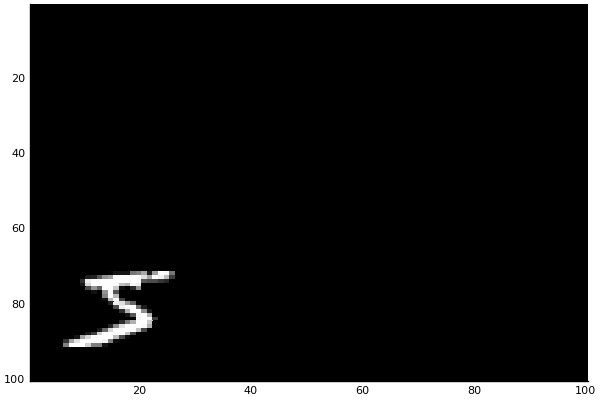

In [38]:
using Plots; pyplot()
totalDim = 100
img = zeros(100,100);
x , y = rand(1:72),rand(1:72)
img[x:(x+27),y:(y+27)] = digitsMNISTtrain_x[:,:,1]
heatmap(img',yflip=true,legend=false,color=:greys)

In [113]:
using Random
Random.seed!(0)

dataLen = 1000
xData = zeros(totalDim,totalDim,1,dataLen);
yData = zeros(13,dataLen);  #pc, x, y, 10 classes

for i in 1:dataLen
    img = zeros(100,100);
    x , y = rand(1:72),rand(1:72)
    if rand() < 0.8
        xData[x:(x+27),y:(y+27),1,i] = digitsMNISTtrain_x[:,:,i]
        yData[1,i] = 1
        yData[2,i] = x
        yData[3,i] = y
        yData[4+digitsMNISTtrain_y[i],i] = 1
    end
    xData[:,:,1,i] += 0.2*rand(totalDim,totalDim)
end

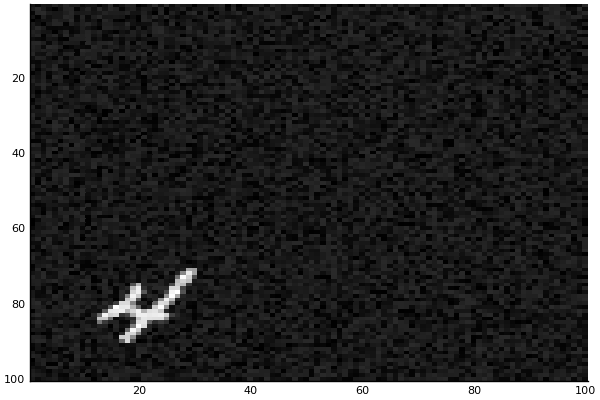

In [114]:
heatmap(xData[:,:,1,10]',yflip=true,legend=false,color=:greys)

In [150]:
using Flux

function buildLocalizationModel()
    Chain(  #Assuming 100x100
      Conv((3, 3), 1 => 8, relu, pad=(0, 0), stride=(1, 1)),   
      BatchNorm(8),
      x -> maxpool(x, (2, 2)),  #16x16x8
      Conv((3, 3), 8 => 4, relu, pad=(0, 0), stride=(1, 1)), #14x14x4  convolutional layer
      BatchNorm(4),
      x -> maxpool(x, (2, 2)), #7x7x4 ,
      flatten,  #196 neurons
      Dense(2116, 80, relu),
      (prev)->vcat( sigmoid.(Dense(80,1)(prev)),
                    Dense(80,1)(prev),
                    Dense(80,1)(prev),
                    softmax(Dense(80,10)(prev))...)
    )
end

modelLocalization = buildLocalizationModel()

Chain(Conv((3, 3), 1=>8, relu), BatchNorm(8), #96, Conv((3, 3), 8=>4, relu), BatchNorm(4), #97, flatten, Dense(2116, 80, relu), #98)

In [151]:
sampleImage = xData[:,:,:,[10]]
# debugModel(modelLocalization)
modelLocalization(sampleImage)

13×1 Array{Float32,2}:
  0.495603
 -0.020295162
 -0.0145284915
  0.096858144
  0.10102488
  0.102372065
  0.102341905
  0.10374058
  0.09806526
  0.09576972
  0.10160684
  0.09938787
  0.09883269

**Extra task:** Finish off the simple localization example.